Prepared for Assignment 1 - Prediction with Machine Learning for Economists course.

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess

warnings.filterwarnings("ignore")

In [2]:
# Loading the data
cps = pd.read_csv("https://osf.io/download/4ay9x/")
# print(cps.head())  # To check if data loads correctly

In [3]:
# Import the prewritten helper functions
from py_helper_functions import *

## FILTERING DATA
Teacher Assistants is the occupation chosen.

In [ ]:
# Count the number of rows where 'occ2012' is 2540 (Teacher Assistants)
count_2540 = cps[cps['occ2012'] == 2540].shape[0]

# Print the result
print(f"Number of observations for occupation code 2540: {count_2540}")

Number of observations for occupation code 2540: 1137


In [5]:
# Filtering and saving the dataset with TA occupation
cps_filtered = cps[cps['occ2012'] == 2540]

import os

# Get the current working directory
current_dir = os.getcwd()

# Define the file path using the current directory
file_path = os.path.join(current_dir, "cps_2540_observations.csv")

output_folder = os.path.join(current_dir, "outputs")
os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist

file_path = os.path.join(output_folder, "cps_2540_observations.csv")
cps_filtered.to_csv(file_path, index=False)

print(f"CSV saved in: {file_path}")

CSV saved in: /Users/ayazhantoktargazy/Downloads/assignment-1/outputs/cps_2540_observations.csv


## NEW VARIABLES
Creating female (binary variable for gender), hourly wage and log of hourly wage.

In [143]:
# CREATE VARIABLES
cps_filtered["female"] = (cps_filtered.sex == 2).astype(int)
cps_filtered["w"] = cps_filtered["earnwke"] / cps_filtered["uhours"]
cps_filtered["lnw"] = np.log(cps_filtered["w"])

In [9]:
## Write out to csv
cps_filtered.to_csv(file_path, index=False)

In [10]:
#####################
# DISTRIBUTION OF EARNINGS
#######################
cps_filtered.loc[:, ["earnwke", "uhours", "w"]].describe()

,earnwke,uhours,w
count,1137.000000,1137.000000,1137.000000
mean,523.106702,33.304310,15.626155
std,375.702023,8.609419,10.876044
min,14.500000,2.000000,0.414286
25%,297.150000,30.000000,9.615333
50%,423.000000,35.000000,12.750000
75%,601.610000,40.000000,17.600000
max,2884.610000,70.000000,154.000000


In [11]:
cps_filtered.loc[cps_filtered.w >= 1, ["earnwke", "uhours", "w"]].describe()

,earnwke,uhours,w
count,1136.000000,1136.000000,1136.000000
mean,523.554419,33.302817,15.639546
std,375.563922,8.613064,10.871453
min,16.500000,2.000000,2.500000
25%,297.412500,30.000000,9.615333
50%,423.035000,35.000000,12.751447
75%,602.145000,40.000000,17.612500
max,2884.610000,70.000000,154.000000


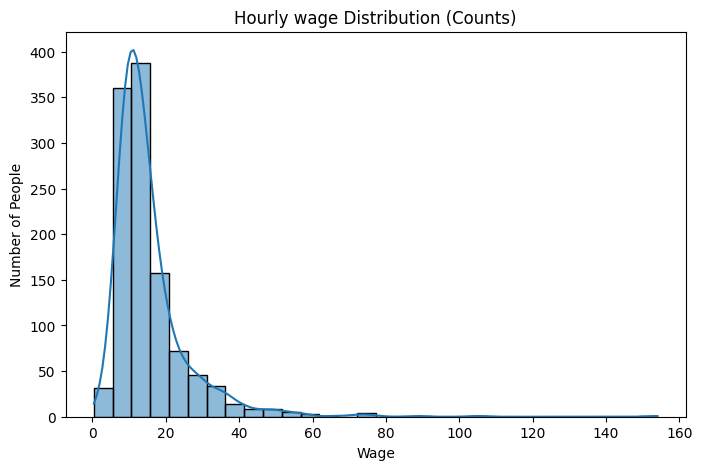

In [12]:
# Plot histogram with counts
plt.figure(figsize=(8, 5))
sns.histplot(cps_filtered['w'], bins=30, kde=True)
plt.xlabel("Wage")
plt.ylabel("Number of People")
plt.title("Hourly wage Distribution (Counts)")
plt.show()

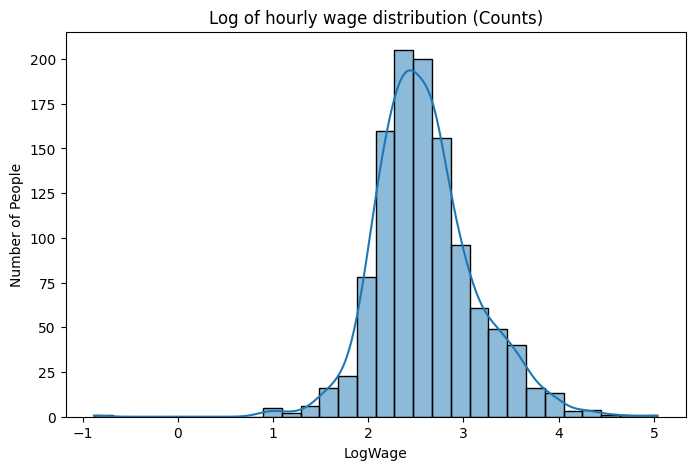

In [13]:
# Plot histogram with counts
plt.figure(figsize=(8, 5))
sns.histplot(cps_filtered['lnw'], bins=30, kde=True)
plt.xlabel("LogWage")
plt.ylabel("Number of People")
plt.title("Log of hourly wage distribution (Counts)")
plt.show()

Log of hourly wage looks "more" normally distributed than the absolute value of hourly wages. Therefore, it is chosen as a target variable in further analysis.

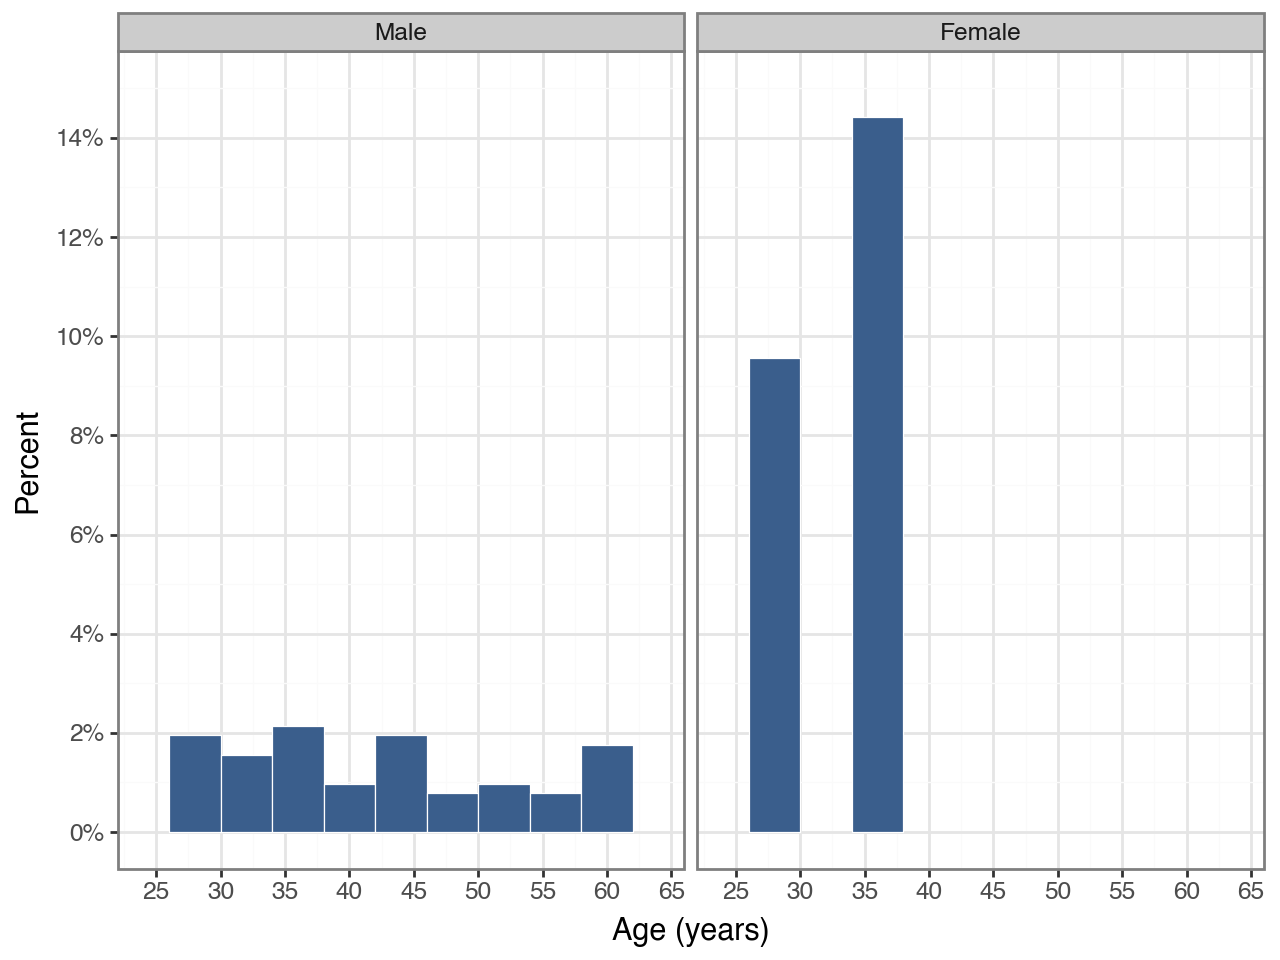

In [16]:
(
    ggplot(cps_filtered, aes(x="age", y="2*stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=4,
        color="white",
        fill=color[0],
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="Age (years)", y="Percent")
    + facet_wrap("~female", labeller={"0": "Male", "1": "Female"})
    + labs(x="Age (years)", y="Percent")
    + scale_x_continuous(
        limits=(24, 64),
        breaks=seq(25, 65, by=5),
    )
    + scale_y_continuous(
        limits=(0, 0.15), breaks=seq(0, 0.15, by=0.02), labels=percent_format()
    )
    + theme_bw()
)

Age distribution for females and males differ a lot.

New binary variables for depicting education level

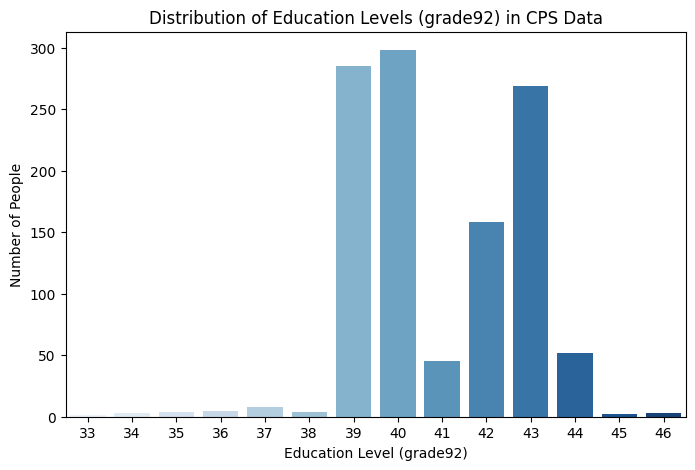

In [144]:
# Count occurrences of each education level
grade92_counts = cps_filtered["grade92"].value_counts().sort_index()

# Plot distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=grade92_counts.index, y=grade92_counts.values, palette="Blues")

# Labels and title
plt.xlabel("Education Level (grade92)")
plt.ylabel("Number of People")
plt.title("Distribution of Education Levels (grade92) in CPS Data")

# Show the plot
plt.show()

In [147]:
# Create binary indicators for different education levels

# Create a new binary variable for Less than High School
cps_filtered["ed_Less_HS"] = cps_filtered["grade92"].isin([31, 32, 33, 34, 35, 36, 37, 38]).astype(int)

# Distinct levels
cps_filtered["ed_HS"] = (cps_filtered["grade92"] == 39).astype(int)
cps_filtered["ed_SomeCollege"] = (cps_filtered["grade92"] == 40).astype(int)
cps_filtered["ed_Assoc_Voc"] = (cps_filtered["grade92"] == 41).astype(int)
cps_filtered["ed_Assoc_Academic"] = (cps_filtered["grade92"] == 42).astype(int)
cps_filtered["ed_BA"] = (cps_filtered["grade92"] == 43).astype(int)
cps_filtered["ed_MA"] = (cps_filtered["grade92"] == 44).astype(int)

# Create a new binary variable for Advanced Degrees (Professional + PhD)
cps_filtered["ed_Advanced"] = cps_filtered["grade92"].isin([45, 46]).astype(int)

In [47]:
# Create binary Government variable (1 = Government, 0 = Private)
cps_filtered["Government"] = cps_filtered["class"].isin(["Government - Local", "Government - State", "Government - Federal"]).astype(int)

# Check distribution
print(cps_filtered["Government"].value_counts())

Government
1    816
0    321
Name: count, dtype: int64


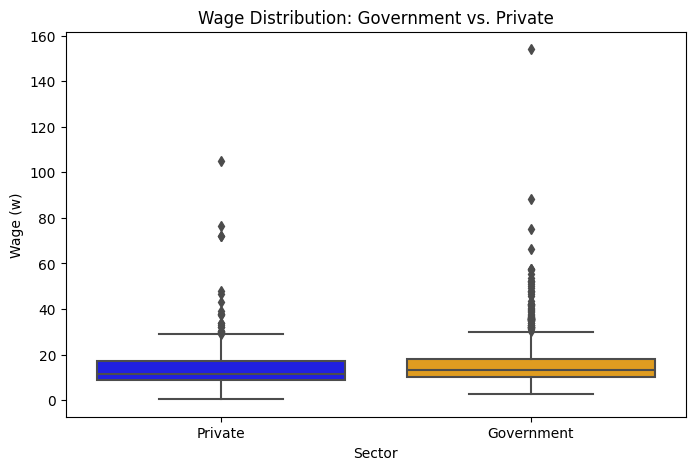

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.boxplot(x="Government", y="w", data=cps_filtered, palette=["blue", "orange"])
plt.xticks(ticks=[0, 1], labels=["Private", "Government"])
plt.xlabel("Sector")
plt.ylabel("Wage (w)")
plt.title("Wage Distribution: Government vs. Private")
plt.show()

High School or Some College (Baseline):
- High school graduate (diploma or GED) (grade92 == 39)
- Some college, no degree (grade92 == 40)
- Associate degree — occupational/vocational (grade92 == 41)
- Associate degree — academic program (grade92 == 42)

Bachelor’s Degree:
- Bachelor's degree (e.g., BA, AB, BS) (grade92 == 43)

Advanced Degrees:
- Master's degree (e.g., MA, MS, MEng, MEd, MSW, MBA) (grade92 == 44)
- Professional school degree (e.g., MD, DDS, DVM, LLB, JD) (grade92 == 45)
- Doctorate degree (e.g., PhD, EdD) (grade92 == 46)

In [149]:
# Grouping education levels:

cps_filtered["ed_HS_SomeCollege"] = cps_filtered["grade92"].isin([39, 40, 41, 42]).astype(int)
cps_filtered["ed_BA"] = (cps_filtered["grade92"] == 43).astype(int)
cps_filtered["ed_Advanced"] = cps_filtered["grade92"].isin([44, 45, 46]).astype(int)


## MODELS

In [ ]:
###################################
# Linear regressions

# Model 1: Regression on age
# model1 = "lnw ~ female"
model1 = "lnw ~ age + agesq"

# Models 2-5: Multiple linear regressions
# note: condition - missing will be baseline for regs
model2 = "lnw ~ female + age + agesq"

model3 = "lnw ~ female + age + agesq + ed_HS_SomeCollege + ed_BA + ed_Advanced"

model4 = """
lnw ~ female + age + agesq + ed_HS_SomeCollege + ed_BA + ed_Advanced + Government
      + female:age + female:agesq + female:ed_HS_SomeCollege + female:ed_BA + female:ed_Advanced + female:Government
"""


model_eq = [model1, model2, model3, model4]

- MODEL 1

Assesses whether hourly wages can be explained by age.

The quaratic term allows for the assumption that growth rate of the effect slows over time.

- MODEL 2

Includes female as a standalone variable (β₁), meaning there is a direct gender wage gap.

Includes female × age interaction (β₃), so the effect of age on wages differs by gender.

Includes female × agesq interaction (β₅), capturing gender differences in age-wage growth patterns.

- MODEL 3

Expands on MODEL 2 by adding education levels. When all education binary variables are set to 0, the workers with no school diploma (the omitted category) are considered.

- MODEL 4

Controls for gender wage gap (female).

Captures how age effects differ by gender (female × age, female × agesq).

Controls for education level.

Controls for government vs. private sector (Government).

Allows education to have different effects for men vs. women (ed_BA × female, etc.).

Allows the government wage premium to differ by gender (Government × female).

In [151]:
regs = []
for equation in model_eq:
    regs.append(smf.ols(equation, cps_filtered).fit(cov_type="HC1"))

# fitted models are now kept in regs

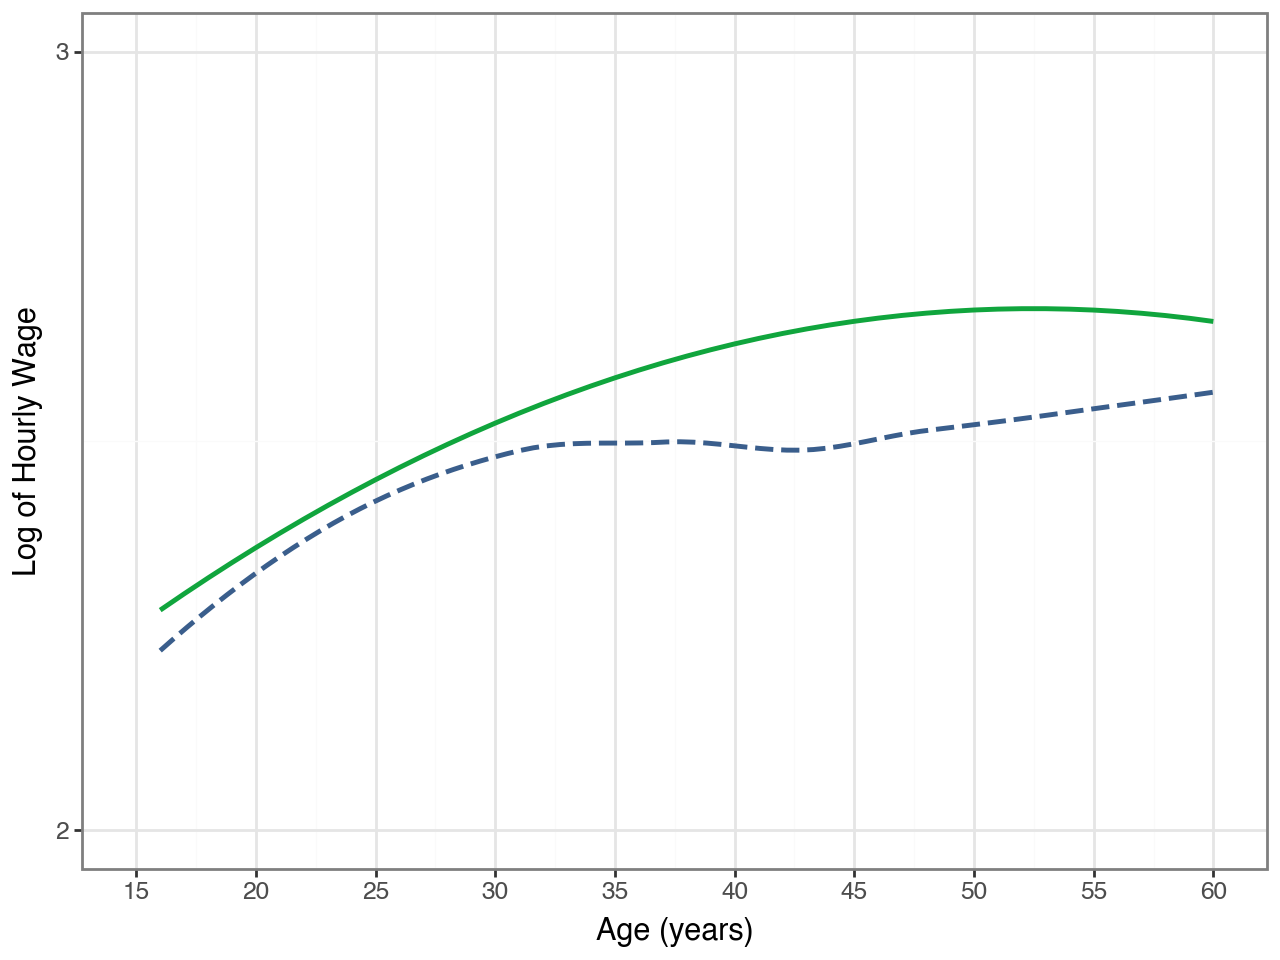

In [155]:
(
    ggplot(cps_filtered, aes(x="age"))
    + geom_smooth(
        aes(y="lnw"),
        colour=color[0],
        linetype="dashed",
        method="loess",
        se=False,
        size=1,
    )
    + geom_line(aes(y="regs[0].predict()"), colour=color[1], size=1)
    + labs(x="Age (years)", y="Log of Hourly Wage")
    + theme_bw()
    + scale_x_continuous(limits=(15, 60), breaks=seq(15, 60, 5))
    + scale_y_continuous(limits=(2, 3), breaks=seq(0, 3, 1))
)

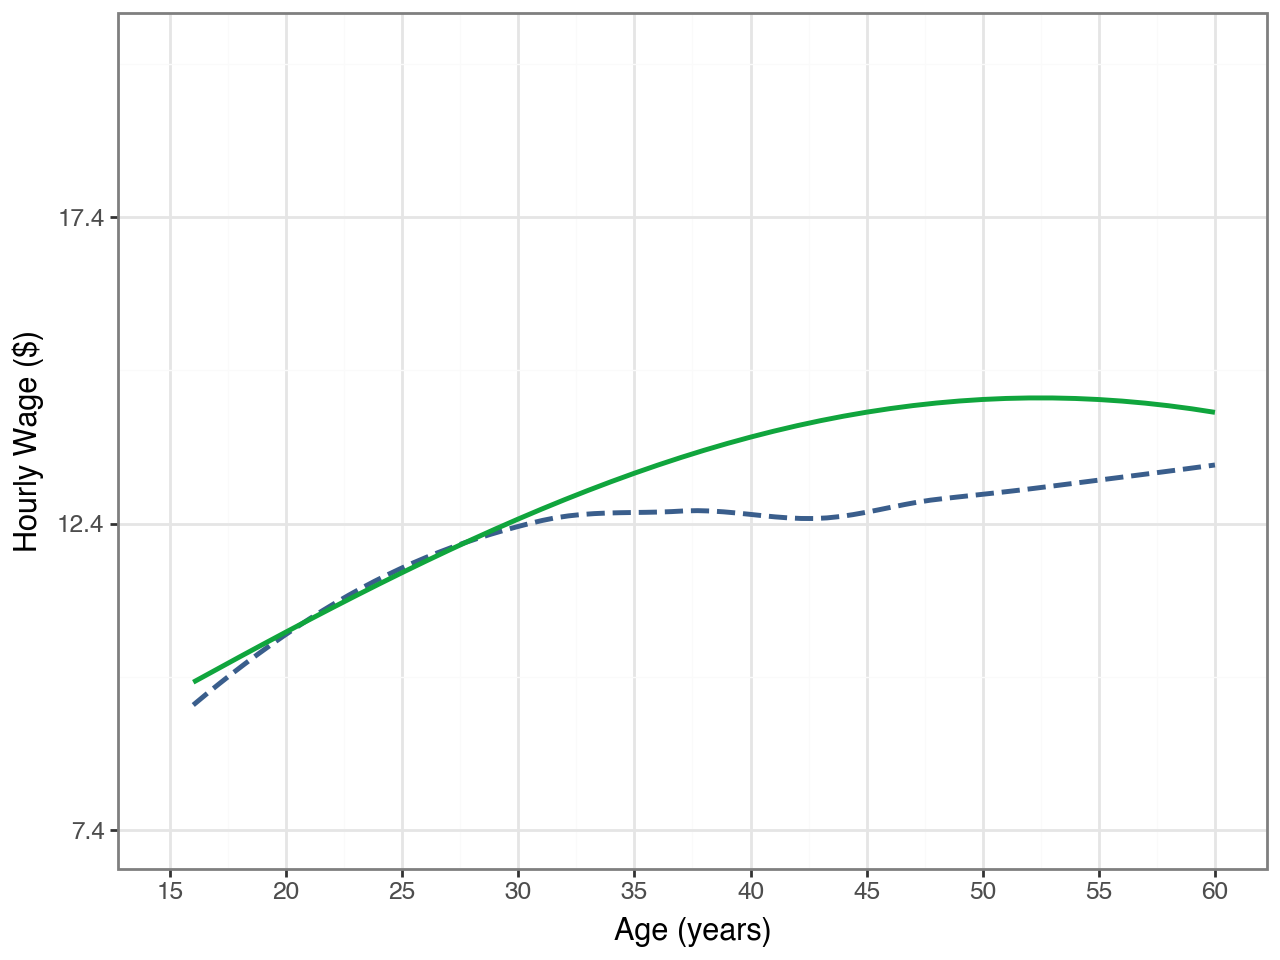

In [156]:
(
    ggplot(cps_filtered, aes(x="age"))
    + geom_smooth(
        aes(y=np.exp(cps_filtered["lnw"])),  # Convert log-wage back to actual wage
        colour=color[0],
        linetype="dashed",
        method="loess",
        se=False,
        size=1,
    )
    + geom_line(aes(y=np.exp(regs[0].predict())), colour=color[1], size=1)  # Convert fitted values
    + labs(x="Age (years)", y="Hourly Wage ($)")
    + theme_bw()
    + scale_x_continuous(limits=(15, 60), breaks=seq(15, 60, 5))
    + scale_y_continuous(limits=(np.exp(2), np.exp(3)), breaks=seq(np.exp(2), np.exp(3), 5))  # Adjust y-axis for wage
)


Add gender-based faceting for visualization (Model 1 and Model 2)

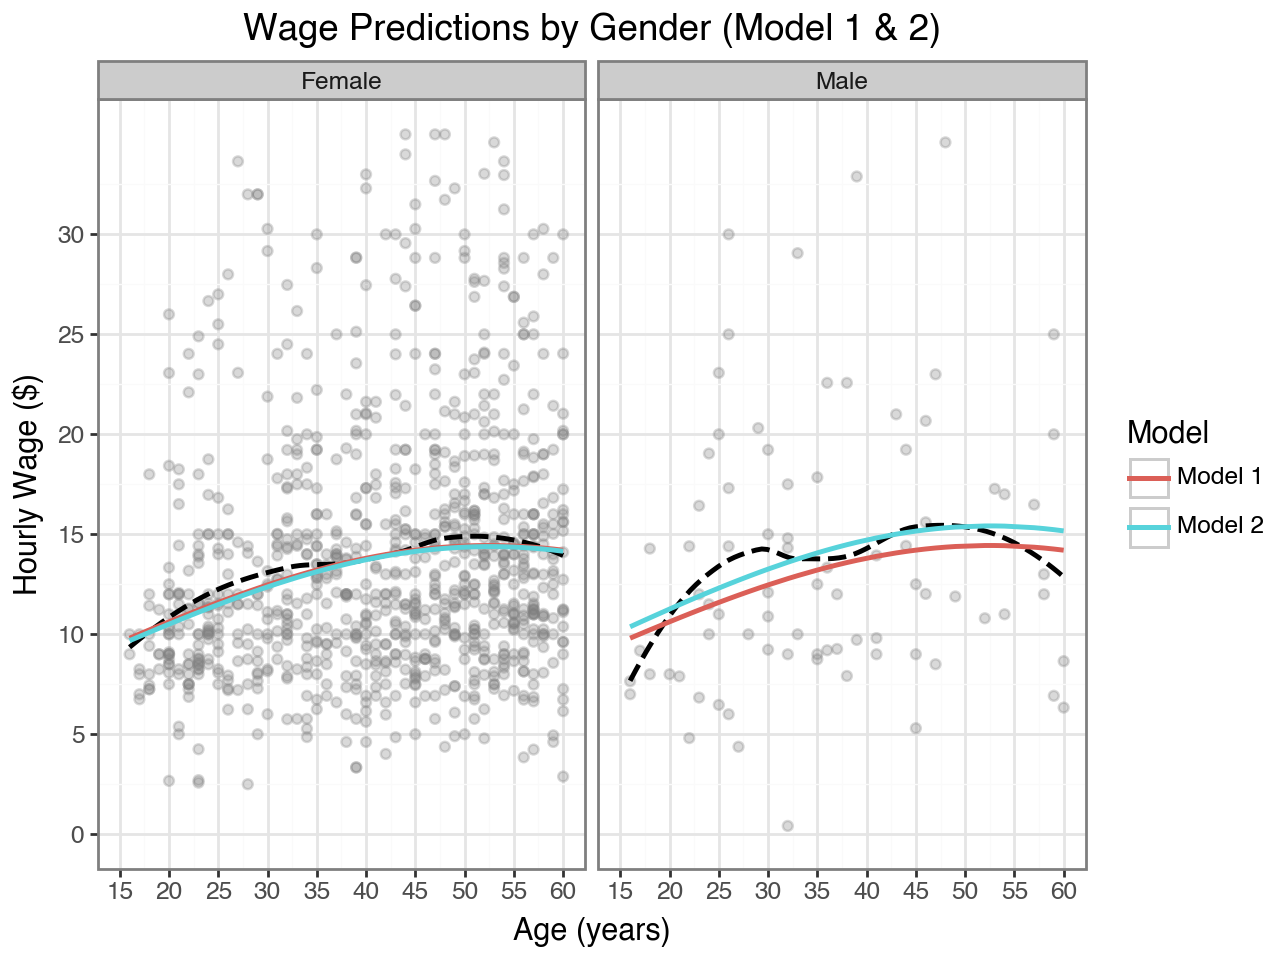

In [157]:
import pandas as pd
import numpy as np
from plotnine import *

# Step 1: Convert 'female' into a categorical variable
cps_filtered["Gender"] = cps_filtered["female"].map({0: "Male", 1: "Female"})

# Step 2: Create a DataFrame for predictions, explicitly labeling gender
pred_df = pd.DataFrame({
    "age": cps_filtered["age"],
    "Gender": cps_filtered["Gender"],  # Proper categorical labeling
    "Model 1": np.exp(regs[0].predict()),  # Predictions from Model 1
    "Model 2": np.exp(regs[1].predict()),  # Predictions from Model 2
})

# Step 3: Convert to long format (DO NOT MELT 'female'!)
pred_long = pred_df.melt(id_vars=["age", "Gender"], var_name="Model", value_name="Wage")

# Step 4: Plot with faceting by gender
(
    ggplot(cps_filtered)
    + geom_point(aes(x="age", y="w"), alpha=0.3, color="gray")  # Actual wage data
    + geom_smooth(
        aes(x="age", y="w"),  
        colour="black", linetype="dashed", method="loess", se=False, size=1  
    )  
    + geom_line(
        pred_long, aes(x="age", y="Wage", color="Model"), size=1  
    )
    + labs(x="Age (years)", y="Hourly Wage ($)", title="Wage Predictions by Gender (Model 1 & 2)")
    + theme_bw()
    + scale_x_continuous(limits=(15, 60), breaks=range(15, 65, 5))
    + scale_y_continuous(limits=(0, 35), breaks=range(0, 35, 5))
    + theme(legend_position="right")
    + facet_wrap("~Gender")  # Now using properly labeled Gender column
)

In [164]:
stargazer = Stargazer(regs[:4])

# Specify the order of covariates
stargazer.covariate_order([
    "age", "agesq", "female", "female:age", "female:agesq",  
    "ed_HS_SomeCollege", "female:ed_HS_SomeCollege",
    "ed_BA", "female:ed_BA", 
    "ed_Advanced", "female:ed_Advanced",
    "Government", "female:Government", 
    "Intercept"
])

# Rename variables for readability
stargazer.rename_covariates({
    "age": "Age",
    "agesq": "Age Squared",
    "female": "Female",
    "female:age": "Female × Age",
    "female:agesq": "Female × Age²",
    "ed_HS_SomeCollege": "High School / Some College",
    "female:ed_HS_SomeCollege": "Female × HS / Some College",
    "ed_BA": "Bachelor’s Degree",
    "female:ed_BA": "Female × BA",
    "ed_Advanced": "Advanced Degree",
    "female:ed_Advanced:": "Female × Advanced",
    "Government": "Government Job",
    "female:Government": "Female × Government",
    "Intercept": "Constant"
})

# Set custom column labels
stargazer.custom_columns(["Model 1", "Model 2", "Model 3", "Model 4"], [1, 1, 1, 1])

# Display the table as HTML (best for Jupyter)
display(HTML(stargazer.render_html()))


## CROSS VALIDATION

Use custom function ols_crossvalidator for cross validation

In [ ]:
help(ols_crossvalidator)

Help on function ols_crossvalidator in module py_helper_functions:

ols_crossvalidator(formula: str, data: pandas.core.frame.DataFrame, n_folds=5, average_rmse=True) -> dict
    OLS cross-validator
    
    
    Estimates `formula` equation with OLS and returns values of RMSE, R`2, No. coefficients,
    BIC on `data`. Does k-fold cross-validation and either returns train and test RMSE for each
    fold, or return averarage train and test RMSEs.
    
    Parameters
    ----------
    formula : str
        Equation that is estimated by OLS.
    data : pd.DataFrame
        Database in a wide format.
    n_folds : int, default=5
        Number of folds. Must be at least 2.
    average_rmse : bool, default=True
        Whether to return the average train and test RMSE of the k-fold CV, or return
        train and test RMSE-s for each fold.



Set n_fold = 4 for 4-fold cross-validation

In [170]:
n_fold = 4

In [171]:
cv_list = []
for equation in model_eq:
    cv_list.append(ols_crossvalidator(equation, cps_filtered, n_fold, average_rmse=False))

In [178]:
(
    pd.DataFrame(cv_list)
    .round(3)
    .assign(
        RMSE=lambda x: x["RMSE"].round(3),
        BIC=lambda x: x["BIC"].astype(int),
        Coefficients=lambda x: x["Coefficients"].astype(int),
        Model=["Model " + str(i + 1) for i in range(len(model_eq))],
        Nvars=[1, 2, 3, 4],
    )
    .filter(["Model", "Nvars", "Coefficients", "R-squared", "RMSE", "BIC"])
    .set_index("Model")
)

,Nvars,Coefficients,R-squared,RMSE,BIC
Model,,,,,
Model 1,1,3,0.033,0.520,1760
Model 2,2,4,0.034,0.520,1765
Model 3,3,7,0.047,0.516,1772
Model 4,4,14,0.053,0.514,1813


In [198]:
pd.DataFrame(
    [cv["Test RMSE"] for cv in cv_list],
    index=["Model " + str(i + 1) for i in range(len(cv_list))],
    columns=["Fold" + str(i + 1) for i in range(len(cv_list[0]["Test RMSE"]))],
).assign(Average=lambda x: x.mean(axis=1)).T.round(2)

,Model 1,Model 2,Model 3,Model 4
Fold1,0.51,0.51,0.51,0.51
Fold2,0.55,0.54,0.55,0.55
Fold3,0.54,0.54,0.53,0.53
Fold4,0.49,0.49,0.49,0.50
Average,0.52,0.52,0.52,0.52


In [224]:
# Number of models
models = ['Model 1', 'Model 2', 'Model 3', 'Model 4']

# Initialize lists to store the values for RMSE and BIC
rmse_full_sample = []
rmse_cv = []
bic = []

# Loop through cv_list to extract performance metrics
for i, result in enumerate(cv_list):
    # Extract the Full Sample RMSE and BIC (assuming `result` has keys for these)
    rmse_full_sample.append(result['RMSE'])  # Replace with the correct key for RMSE in full sample
    bic.append(result['BIC'])  # Replace with the correct key for BIC in full sample
    
    # Cross-Validation RMSE (assuming `result['Test RMSE']` is a list of RMSE values across folds)
    rmse_cv.append(np.mean(result['Test RMSE']))  # Averaging across folds using numpy


In [225]:
# Create a DataFrame to store the extracted values
df = pd.DataFrame({
    'Model': models,
    'RMSE (Full Sample)': rmse_full_sample,
    'RMSE (Cross-Validated)': rmse_cv,
    'BIC': bic
})


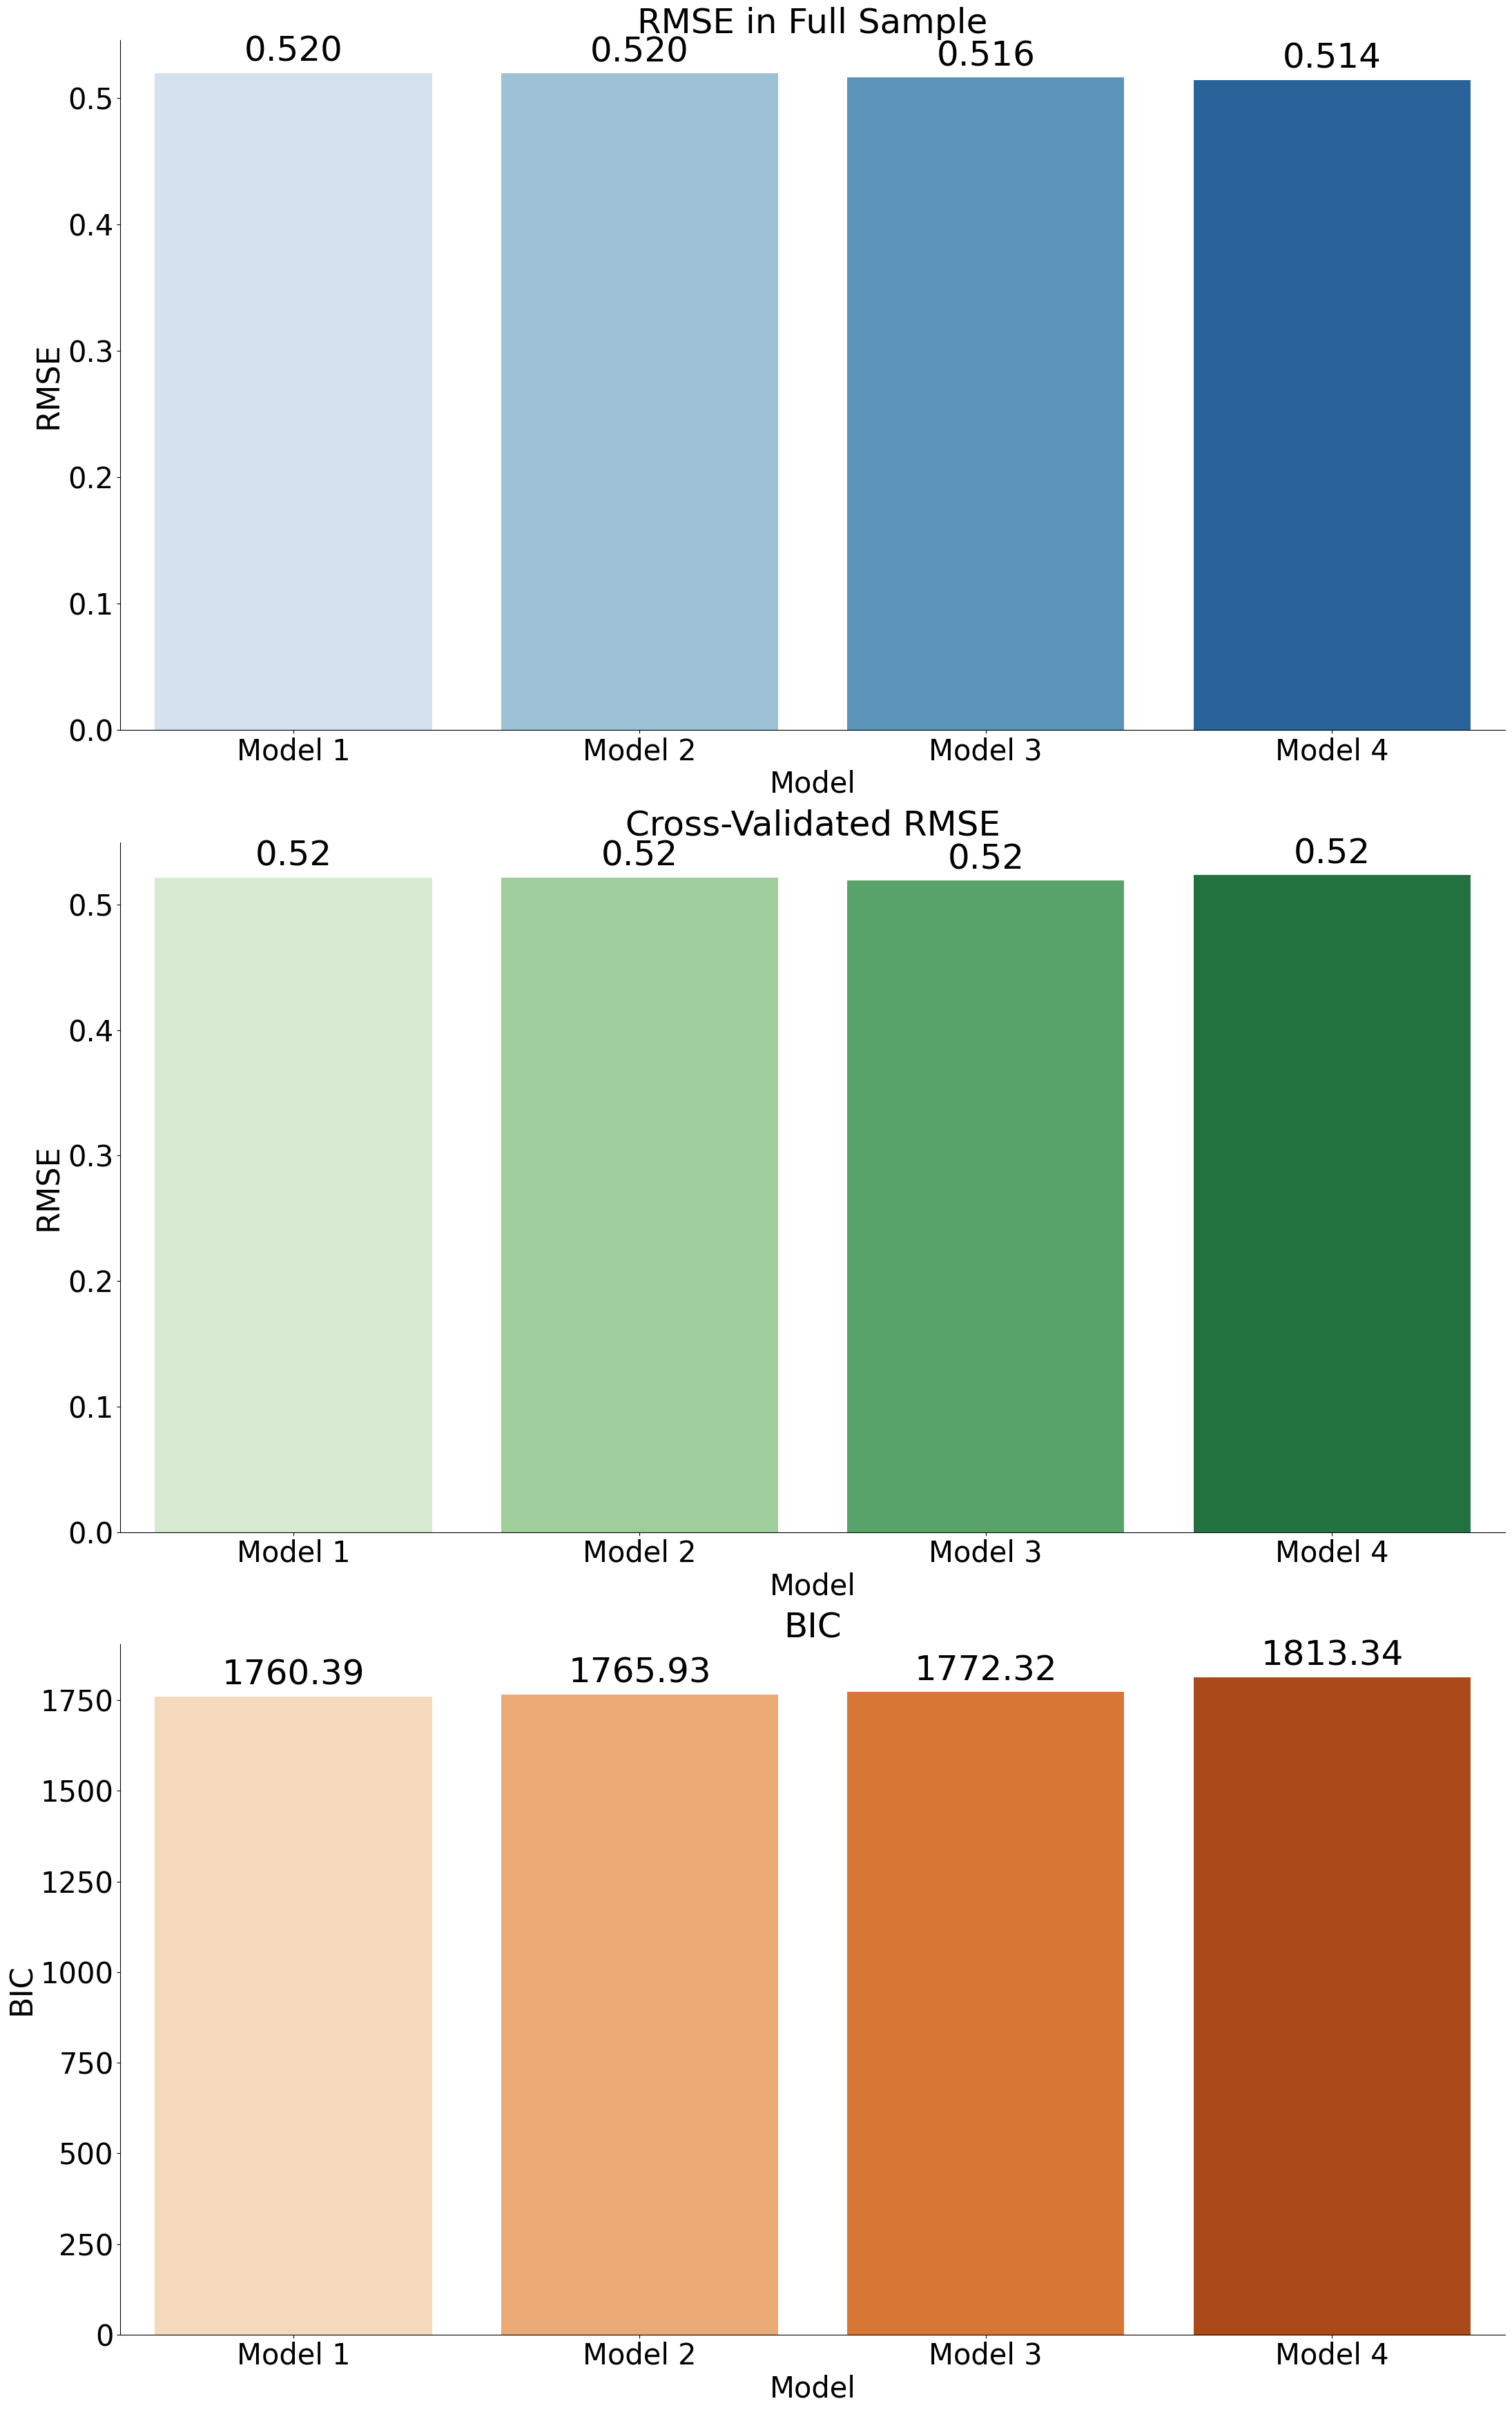

In [254]:
# Plot the comparison between the models
fig, axes = plt.subplots(3, 1, figsize=(22, 35))

# Plot RMSE in the full sample
sns.barplot(x='Model', y='RMSE (Full Sample)', data=df, ax=axes[0], palette="Blues")
axes[0].set_title("RMSE in Full Sample", fontsize=36)
axes[0].set_ylabel("RMSE", fontsize=36)   

# Add numbers on top of the bars for Full Sample RMSE
for p in axes[0].patches:
    axes[0].annotate(format(p.get_height(), '.3f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     xytext=(0, 5),
                     textcoords='offset points',
                     ha='center', va='bottom', fontsize=36)
    
# Remove top and right edges of the plot
sns.despine(ax=axes[0], top=True, right=True)

# Plot Cross-Validated RMSE
sns.barplot(x='Model', y='RMSE (Cross-Validated)', data=df, ax=axes[1], palette="Greens")
axes[1].set_title("Cross-Validated RMSE", fontsize=36)
axes[1].set_ylabel("RMSE", fontsize=36)

# Add numbers on top of the bars for Cross-Validated RMSE
for p in axes[1].patches:
    axes[1].annotate(format(p.get_height(), '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     xytext=(0, 5),
                     textcoords='offset points',
                     ha='center', va='bottom', fontsize=36)

# Remove top and right edges of the plot
sns.despine(ax=axes[1], top=True, right=True)

# Plot BIC
sns.barplot(x='Model', y='BIC', data=df, ax=axes[2], palette="Oranges")
axes[2].set_title("BIC", fontsize=36)
axes[2].set_ylabel("BIC", fontsize=36)

# Add numbers on top of the bars for BIC
for p in axes[2].patches:
    axes[2].annotate(format(p.get_height(), '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     xytext=(0, 5),
                     textcoords='offset points',
                     ha='center', va='bottom', fontsize=36)

# Remove top and right edges of the plot
sns.despine(ax=axes[2], top=True, right=True)

# Increase font size for the x-axis labels (model names) and y-axis ticks
for ax in axes:
    ax.set_xlabel("Model", fontsize=30)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=30, rotation=0)  # x-axis label size and no rotation
    ax.set_ylabel(ax.get_ylabel(), fontsize=32)  # y-axis label size
    ax.tick_params(axis='y', labelsize=30)  # Increase font size of y-axis numbers

# Adjust layout for better spacing between plots
plt.subplots_adjust(hspace=0.9)  # Add space between the plots

# Adjust layout for better spacing
plt.tight_layout()
plt.show()